# Project description

For this opportunity we're going to explore **Ham and Spam emails from SpamAssasin** provided at https://www.kaggle.com/veleon/ham-and-spam-dataset - It contains several email files all readable by Python Email library. I'll import all of them, explore them, determine commonly used words in Spam emails, will train some models based on the files in order to find the best that fits the data and finally start predicting.

In [1]:
import numpy as np
import pandas as pd
import os
import email
import email.policy
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

#Let's explore the directory segmentation
os.listdir('/kaggle/input/ham-and-spam-dataset/')

['spam', 'ham', 'hamnspam']

# Data exploration

In [2]:
ham_filenames = [name for name in sorted(os.listdir('/kaggle/input/ham-and-spam-dataset/ham/')) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir('/kaggle/input/ham-and-spam-dataset/spam')) if len(name) > 20]

## Dataset structure

In [3]:
#How's the dataset structure? How many ham/spam emails does it contain?

print('Total ham emails: ',len(ham_filenames))
print('Total spam emails: ',len(spam_filenames))
print('Spam percentage: ',100*(len(spam_filenames)/(len(ham_filenames)+len(spam_filenames))))

Total ham emails:  2551
Total spam emails:  501
Spam percentage:  16.41546526867628


In [4]:
#Let's load an email to see how it looks like:

#Using email.parser: https://docs.python.org/3/library/email.parser.html
#"The email package provides a standard parser that understands most email document structures, including MIME documents"

with open(os.path.join('/kaggle/input/ham-and-spam-dataset/ham/', ham_filenames[0]), "rb") as file:
    ham_email =  email.parser.BytesParser(policy=email.policy.default).parse(file)

print('Header field names: ',ham_email.keys())
print('\n -------------------------------------- \n')
print('Message field values: ',ham_email.values())
print('\n -------------------------------------- \n')
print('Message content:',ham_email.get_content()[:500])

Header field names:  ['Return-Path', 'Delivered-To', 'Received', 'Received', 'Received', 'Received', 'Delivered-To', 'Received', 'Received', 'Received', 'Received', 'Received', 'Received', 'From', 'To', 'Cc', 'Subject', 'In-Reply-To', 'References', 'MIME-Version', 'Content-Type', 'Message-Id', 'X-Loop', 'Sender', 'Errors-To', 'X-Beenthere', 'X-Mailman-Version', 'Precedence', 'List-Help', 'List-Post', 'List-Subscribe', 'List-Id', 'List-Unsubscribe', 'List-Archive', 'Date']

 -------------------------------------- 

Message field values:  ['<exmh-workers-admin@example.com>', 'zzzz@localhost.netnoteinc.com', 'from localhost (localhost [127.0.0.1])\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36\tfor <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)', 'from phobos [127.0.0.1]\tby localhost with IMAP (fetchmail-5.9.0)\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)', 'from listman.example.com (listman.example.com [66.187.233.211]) by    dogma

In [5]:
#Let's extract some email fields

email_subject = ham_email.get_all('Subject')
email_from = ham_email.get_all('From')
email_to = ham_email.get_all('To')

print('Email from: ',email_from)
print('Email to: ',email_to)
print('Email subject: ',email_subject)

Email from:  ['Robert Elz <kre@munnari.OZ.AU>']
Email to:  ['Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>']
Email subject:  ['Re: New Sequences Window']


# Data Importing
Now that we've explored how the data is structured, we are going to import all emails to be processed later on the notebook.

In [6]:
def upload_ham(filename):
    """This function process a ham email file located at a specified directory and returns it as an email object"""
    directory = '/kaggle/input/ham-and-spam-dataset/ham/'
    with open(os.path.join(directory, filename), "rb") as file:
        return email.parser.BytesParser(policy=email.policy.default).parse(file)

def upload_spam(filename):
    """This function process a spam email file located at a specified directory and returns it as an email object"""
    directory = '/kaggle/input/ham-and-spam-dataset/spam/'
    with open(os.path.join(directory, filename), "rb") as file:
        return email.parser.BytesParser(policy=email.policy.default).parse(file)
    
ham_emails = [upload_ham(filename=name) for name in ham_filenames]
spam_emails = [upload_spam(filename=name) for name in spam_filenames]

In [7]:
#Checking if everything was uploaded properly:

print(ham_emails[0].get_all('Subject'))
print(ham_emails[0].get_content())
print('\n\n -----------------------------------------------------------\n\n')
print(spam_emails[1].get_all('Subject'))
print(spam_emails[1].get_content())

['Re: New Sequences Window']
    Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>


  | I can't reproduce this error.

For me it is very repeatable... (like every time, without fail).

This is the debug log of the pick happening ...

18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ...

Note, if I run the pick command by hand ...

delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit

That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using is ...

delta$ pick -version
pick -- nmh-1.0.4 [compiled on fuchsia.cs

# **Converting emails to plain text**
In the previous output you could notice that there are some emails with HTML format. We need them to be plain text format.

In [8]:
#Let's research about what email content types are:

ham_email_types = []
spam_email_types = []

for i in range(len(ham_filenames)):
    ham_email_types.append(ham_emails[i].get_content_type())

for i in range(len(spam_filenames)):
    spam_email_types.append(spam_emails[i].get_content_type())

print('Ham content types: ',set(ham_email_types))
print('Spam content types: ',set(spam_email_types))

Ham content types:  {'text/plain', 'multipart/related', 'multipart/signed', 'multipart/alternative', 'multipart/report', 'multipart/mixed'}
Spam content types:  {'text/html', 'text/plain', 'multipart/related', 'multipart/alternative', 'multipart/mixed'}


In [9]:
#We need to identify what the multipart emails are structured of

def email_content_type(email):
    """This function returns the content type of an email and if it has a multipart shape then returns the multiparts type"""
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([email_content_type(sub_email) for sub_email in payload]))
    else:
        return email.get_content_type()

In [10]:
ham_email_types = []
spam_email_types = []

for i in range(len(ham_filenames)):
    ham_email_types.append(email_content_type(ham_emails[i]))

for i in range(len(spam_filenames)):
    spam_email_types.append(email_content_type(spam_emails[i]))

print('Ham content types: ',set(ham_email_types))
print('Spam content types: ',set(spam_email_types))

Ham content types:  {'multipart(text/plain, application/x-pkcs7-signature)', 'text/plain', 'multipart(text/plain, text/html)', 'multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)', 'multipart(text/plain, application/ms-tnef, text/plain)', 'multipart(text/plain, application/pgp-signature)', 'multipart(text/plain, application/octet-stream)', 'multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)', 'multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))', 'multipart(text/plain, application/x-java-applet)', 'multipart(text/plain, text/plain)', 'multipart(text/plain, multipart(text/plain))', 'multipart(text/plain)', 'multipart(text/plain, text/enriched)', 'multipart(text/plain, video/mng)'}
Spam content types:  {'text/html', 'text/plain', 'multipart(text/plain, text/html)', 'multipart(text/html)', 'multipart(text/plain, application/octet-stream)', 'multipart(text/plain

In [11]:
#Now that we've identified what are the email content types, we need to transform all html emails to plain format.

from bs4 import BeautifulSoup
html = spam_emails[1].get_content()
soup = BeautifulSoup(html)
print(soup.get_text().replace('\n\n',''))

Save up to 70% on Life Insurance.
Why Spend More Than You Have To?Life Quote Savings
Ensuring your 
      family's financial security is very important. Life Quote Savings makes 
      buying life insurance simple and affordable. We Provide FREE Access to The 
      Very Best Companies and The Lowest Rates.Life Quote Savings is FAST, EASY and 
            SAVES you money! Let us help you get started with the best values in 
            the country on new coverage. You can SAVE hundreds or even thousands 
            of dollars by requesting a FREE quote from Lifequote Savings. Our 
            service will take you less than 5 minutes to complete. Shop and 
            compare. SAVE up to 70% on all types of Life insurance! Click Here For Your 
            Free Quote!Protecting your family is the best investment you'll ever 
          make!
If you are in receipt of this email 
      in error and/or wish to be removed from our list, PLEASE CLICK HERE AND TYPE REMOVE. If you 
      resid

In [12]:
#Let's build a function with the previous process to convert all html emails into plain text

def html_to_plain(email):
    soup = BeautifulSoup(email.get_content())
    return soup.get_text().replace('\n\n','').replace('\n',' ') 

In [13]:
#Now all emails which have/contain HTML tags will be converted to plain text

def email_to_plain(email):
    content_type = email_content_type(email)
    for part in email.walk(): 
        #The .walk() documentation at https://docs.python.org/3/library/email.message.html
        #"The walk() method is an all-purpose generator which can be used to iterate over all 
        #the parts and subparts of a message object tree, in depth-first traversal order."
        partContentType = part.get_content_type()
        if partContentType not in ['text/plain','text/html']:
            continue
        try:
            partContent = part.get_content()
        except: 
            partContent = str(part.get_payload())
        if partContentType == 'text/plain':
            return partContent
        else:
            return html_to_plain(part)

In [14]:
#Let's test this out.
email_test1 = email_to_plain(spam_emails[1])
email_test2 = email_to_plain(spam_emails[227])
print(email_test1)
print('\n\n')
print(email_test2[:1000])

Save up to 70% on Life Insurance. Why Spend More Than You Have To?Life Quote Savings Ensuring your        family's financial security is very important. Life Quote Savings makes        buying life insurance simple and affordable. We Provide FREE Access to The        Very Best Companies and The Lowest Rates.Life Quote Savings is FAST, EASY and              SAVES you money! Let us help you get started with the best values in              the country on new coverage. You can SAVE hundreds or even thousands              of dollars by requesting a FREE quote from Lifequote Savings. Our              service will take you less than 5 minutes to complete. Shop and              compare. SAVE up to 70% on all types of Life insurance! Click Here For Your              Free Quote!Protecting your family is the best investment you'll ever            make! If you are in receipt of this email        in error and/or wish to be removed from our list, PLEASE CLICK HERE AND TYPE REMOVE. If you        resid

In [15]:
#Spam email #226 contains an unknown encoding so we will remove it from the list
del spam_emails[226]

# Building the dataset to train the model
Essentially we'll create a dataframe with the emails' content and their particular label. This will allow us to implement NLP to feed a ML model

In [16]:
ham_dataset = []
spam_dataset = []

#Ham processing
for i in range(len(ham_emails)):
    ham_dataset.append(email_to_plain(ham_emails[i]))
ham_dataset = pd.DataFrame(ham_dataset,columns=['Email content'])
ham_dataset['Label'] = 0

#Spam processing
for i in range(len(spam_emails)):
    spam_dataset.append(email_to_plain(spam_emails[i]))
spam_dataset = pd.DataFrame(spam_dataset,columns=['Email content'])
spam_dataset['Label'] = 1

dataset = pd.concat([ham_dataset,spam_dataset])
dataset.head()

,Email content,Label
0,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
1,"Martin A posted:\nTassos Papadopoulos, the Gre...",0
2,Man Threatens Explosion In Moscow \n\nThursday...,0
3,Klez: The Virus That Won't Die\n \nAlready the...,0
4,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wrot...",0


In [17]:
#We will shuffle the data and also reset indexes
dataset = dataset.dropna()
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

,Email content,Label
0,"[Anthony Baxter]\n> Well, I've finally got aro...",0
1,\n[can't think of how I'd be running\nafoul of...,0
2,ATTENTION: This is a MUST for ALL Computer Use...,1
3,"ok, so if i was in the uk for a wekk, how migh...",0
4,"On Wed, 18 Sep 2002, R. A. Hettinga wrote:\n--...",0


We're gonna implement some NLP in order to facilitate the model to predict well.

In [18]:
#Removing special chars because they just add noise and make the models poor when predicting.
for i in range(len(dataset)):
    dataset.at[i,'Email content'] = dataset.loc[i]['Email content'].replace('!','').replace('?','').replace(',','').replace('[','').replace(']','').replace('(','').replace(')','').replace('...','')
    dataset.at[i,'Email content'] = dataset.loc[i]['Email content'].replace('>','').replace('<','').replace('\n',' ').replace('-','').replace('+','').replace('#','')
dataset.head()

,Email content,Label
0,Anthony Baxter Well I've finally got around t...,0
1,can't think of how I'd be running afoul of th...,0
2,ATTENTION: This is a MUST for ALL Computer Use...,1
3,ok so if i was in the uk for a wekk how might ...,0
4,On Wed 18 Sep 2002 R. A. Hettinga wrote: AA Me...,0


The below function will be used later on the notebook to process the prediction inputs.

In [19]:
def input_preprocessing(text):
    text = text.replace('!','').replace('?','').replace(',','').replace('[','').replace(']','').replace('(','').replace(')','').replace('...','')
    text = text.replace('>','').replace('<','').replace('\n',' ').replace('-','').replace('+','').replace('#','')
    return text

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset['Email content'],dataset['Label'],shuffle=True,random_state=0)

In [21]:
#checking if everything went OK.
print (len(X_train),len(X_test),len(y_train),len(y_test))

2287 763 2287 763


# Model training and selection

We'll go through the use of TfidfVectorizer and CountVectorizer as NLP resources to transform the dataset into a format the classifiers can interpret it. Right after that, we'll train a LogisticRegressor and a Support Vector classifier and the one that performs better will  be selected.

## **CountVectorizer** and **LogisticRegression** classifier ML model.

In [22]:
pipe = make_pipeline(CountVectorizer(min_df=5,analyzer='char_wb'), LogisticRegression(max_iter=10000))
param_grid = {"logisticregression__C": [0.1, 1, 10, 100],
"countvectorizer__ngram_range": [(1, 2), (1, 3),(2,5)]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.98
Best parameters:
{'countvectorizer__ngram_range': (2, 5), 'logisticregression__C': 1}


In [23]:
vect = CountVectorizer(min_df=5, analyzer='char_wb', ngram_range=[2,5])

X_train_vectorized = vect.fit_transform(X_train)
X_test_vectorized = vect.transform(X_test)

clf = LogisticRegression(C=0.1,max_iter=500).fit(X_train_vectorized, y_train)
y_predicted = clf.predict(X_test_vectorized)

In [24]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predicted)))
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_predicted)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predicted)))
print("AUC score: {:.2f}%".format(100 * roc_auc_score(y_test, y_predicted)))

Precision: 98.15%
Accuracy: 98.03%
Recall: 89.08%
AUC score: 94.38%


## **TFIDF** vectorizer and **LogisticRegression** classifier ML model.

In [25]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=10000))
# running the grid search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
"tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3),(2,5)]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.99
Best parameters:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 2)}


In [26]:
vect = TfidfVectorizer(min_df=5,ngram_range=(1,2)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
clf = LogisticRegression(C=100,max_iter=10000).fit(X_train_vectorized, y_train)
y_predicted = clf.predict(X_test_vectorized)

In [27]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predicted)))
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_predicted)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predicted)))
print("AUC score: {:.2f}%".format(100 * roc_auc_score(y_test, y_predicted)))

Precision: 99.09%
Accuracy: 98.56%
Recall: 91.60%
AUC score: 95.72%


## **TFIDF** vectorizer and **Support Vector Classifier** ML model.

In [28]:
vect = TfidfVectorizer(min_df=5,ngram_range=(2,5)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
param_grid = {'C':[1,10,100,1000,10000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']}
grid = GridSearchCV(SVC(),param_grid,refit = True, verbose=0)
grid.fit(X_train_vectorized, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.99
Best parameters:
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [29]:
vect = TfidfVectorizer(min_df=5,ngram_range=(2,5)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
clf = SVC(C=100,gamma= 0.1,kernel='rbf').fit(X_train_vectorized, y_train)
y_predicted = clf.predict(X_test_vectorized)

In [30]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predicted)))
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_predicted)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predicted)))
print("AUC score: {:.2f}%".format(100 * roc_auc_score(y_test, y_predicted)))

Precision: 97.41%
Accuracy: 98.82%
Recall: 94.96%
AUC score: 97.25%


## TFIDF Vectorizer with Random Forest Classifier

In [31]:
vect = TfidfVectorizer(min_df=5,ngram_range=(2,5)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
param_grid = {'max_depth':[2,5,10,20,30,50,100,200],'n_estimators':[10,20,50]}
grid = GridSearchCV(RandomForestClassifier(random_state=0),param_grid,refit = True, verbose=0)
grid.fit(X_train_vectorized, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.97
Best parameters:
{'max_depth': 100, 'n_estimators': 20}


In [32]:
vect = TfidfVectorizer(min_df=5,ngram_range=(2,5)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
clf = RandomForestClassifier(n_estimators=50,max_depth=100,random_state=0).fit(X_train_vectorized, y_train)
y_predicted = clf.predict(X_test_vectorized)

In [33]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predicted)))
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_predicted)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predicted)))
print("AUC score: {:.2f}%".format(100 * roc_auc_score(y_test, y_predicted)))

Precision: 98.92%
Accuracy: 96.33%
Recall: 77.31%
AUC score: 88.58%


## TFIDF Vectorizer with GradientBoosted Classifier

In [34]:
vect = TfidfVectorizer(min_df=5,ngram_range=(2,5)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
param_grid = {'max_depth':[30,50,100]}
grid = GridSearchCV(GradientBoostingClassifier(random_state=0,n_estimators=50),param_grid,refit = True, verbose=0)
grid.fit(X_train_vectorized, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.95
Best parameters:
{'max_depth': 30}


In [35]:
vect = TfidfVectorizer(min_df=5,ngram_range=(2,5)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
clf = GradientBoostingClassifier(max_depth=30,random_state=0).fit(X_train_vectorized, y_train)
y_predicted = clf.predict(X_test_vectorized)

In [36]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predicted)))
print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_predicted)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predicted)))
print("AUC score: {:.2f}%".format(100 * roc_auc_score(y_test, y_predicted)))

Precision: 79.69%
Accuracy: 94.36%
Recall: 85.71%
AUC score: 90.84%


## Model selected: **Support Vector Classifier** with **TFIDF** vectorizer.

In [37]:
vect = TfidfVectorizer(min_df=5,ngram_range=(2,5)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
X_test_vectorized = vect.transform(X_test)
clf = SVC(C=100,gamma= 0.1,kernel='rbf').fit(X_train_vectorized, y_train)
y_predicted = clf.predict(X_test_vectorized)

In [38]:
print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("Features with highest idf:\n{}".format(vect.get_feature_names()[-50:]))

Vocabulary size: 36354
Features with highest idf:
['your tobacco then you', 'your tobacco then you should', 'your total', 'your urgent', 'your urgent reply', 'your use', 'your use of', 'your use of yahoo', 'your use of yahoo groups', 'your user', 'your user page', 'your user page http', 'your user page http use', 'your valuable', 'your valuable information', 'your valuable information and', 'your valuable information and click', 'your very', 'your very first', 'your very first year', 'your very first year of', 'your wallet', 'your website', 'yours faithfully', 'yours for', 'yours for only', 'yours for only 29', 'yours for only 29 99', 'yours now', 'yourself and', 'yourself and your', 'yourself and your family', 'yourself and your family with', 'yourself from', 'yourself from our', 'yourself or', 'yourself with', 'zawodny com', 'zawodny com blog', 'zawodny com blog archives', 'zealot conservative', 'zealot conservative and', 'zealot conservative and technomad', 'zealot conservative and 

## Confusion Matrix

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
matrix = confusion_matrix(y_test, y_predicted)

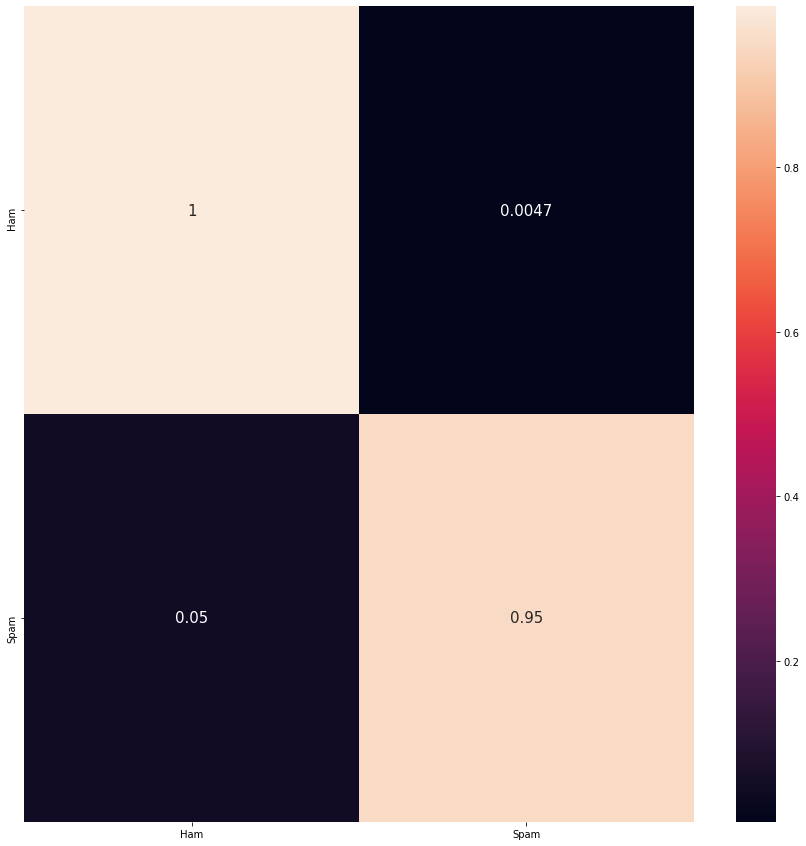

In [40]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Ham','Spam'],columns = ['Ham','Spam'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

Let's simulate some emails to see how our model performs

## Model testing

In [41]:
email_test = ['Good morning mates. This is just to let you all know we have scheduled a meeting for EOD.']
email_test[0] = input_preprocessing(email_test[0])
email_test = vect.transform(email_test)
prediction = clf.predict(email_test)

if prediction == 0:
    print('The email has not been flagged as SPAM.')
else:
    print('The email has been flagged as SPAM.')

The email has not been flagged as SPAM.


In [42]:
email_test = ['Dear Sergio, Flash Sale at Walmart! 25% OFF all weekend!']
email_test[0] = input_preprocessing(email_test[0])
email_test = vect.transform(email_test)
prediction = clf.predict(email_test)

if prediction == 0:
    print('The email has not been flagged as SPAM.')
else:
    print('The email has been flagged as SPAM.')

The email has been flagged as SPAM.
